# Finding Heavy Traffic Indicators on I-94

The I-94 is an east-west interstate that connects the Great Lakes and the northern Great Plains regions of the US

**Length:** 1,585.20 miles (2,551.13 km)

![I-94](https://s3.amazonaws.com/dq-content/524/i94_figma.png)

## Goal

Our aim is to determine a few indicators of heavy traffic on the I-94, between Minneapolis and Saint Paul.
This could include:
- weather type
- time of day
- time of week
- etc

## Dataset

> Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.


Our dataset is collected by John Hogue, and can be found [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

### data columns

- `holiday`: Categorical US National holidays plus regional holiday, Minnesota State Fair
- `temp`: Numeric Average temp in kelvin
- `rain_1h`: Numeric Amount in mm of rain that occurred in the hour
- `snow_1h`: Numeric Amount in mm of snow that occurred in the hour
- `clouds_all`: Numeric Percentage of cloud cover
- `weather_main`: Categorical Short textual description of the current weather
- `weather_description`: Categorical Longer textual description of the current weather
- `date_time`: DateTime Hour of the data collected in local CST time
- `traffic_volume`: Numeric Hourly I-94 ATR 301 reported westbound traffic volume

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

traffic = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

In [2]:
print(traffic.head(5))
print('\n')
print(traffic.tail(5))
print('\n')
print(traffic.info())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  


      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0 

We can examine the distribution of traffic by plotting a histogram of `traffic_volume`

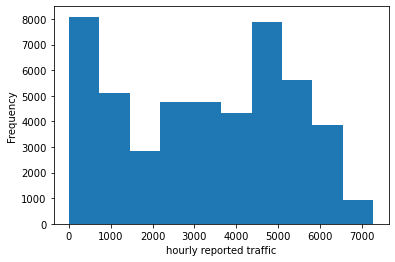

In [3]:
traffic["traffic_volume"].plot.hist()
plt.xlabel("hourly reported traffic")
plt.show()

In [4]:
traffic["traffic_volume"].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

The histogram shows a bimodal distribution of hourly traffic volume. The 2 peaks could correlate to daytime/nighttime since:
- 25% of time, 1193 cars or fewer pass the station each hour
- 25% of time, traffic volume is 4x as much (4933+)

## Time indicators

We can check our correlation by comparing daytime and nighttime data.
- Daytime: 7AM to 7PM
- Nighttime: 7PM to 7AM

In [5]:
traffic["date_time"] = pd.to_datetime(traffic["date_time"])
traffic["date_time"].dt.hour.head()

# 7AM to 7PM (between 7 and 19)
day_bool = (traffic["date_time"].dt.hour >= 7) & (
    traffic["date_time"].dt.hour < 19)

# 7PM to 7AM (between 19 and 7)
night_bool = (traffic["date_time"].dt.hour < 7) | (
    traffic["date_time"].dt.hour >= 19)

day_traffic = traffic[day_bool]
night_traffic = traffic[night_bool]

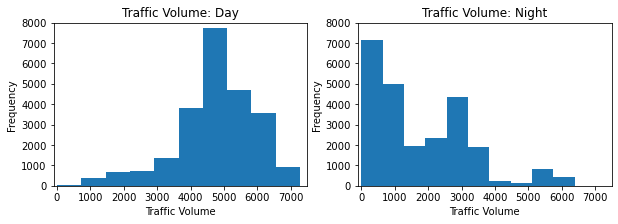

In [6]:
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.hist(day_traffic['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Day')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.subplot(1, 2, 2)
plt.hist(night_traffic['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Night')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.show()

In [7]:
day_traffic['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [8]:
night_traffic['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

The histogram for daytime traffic is left skewed, meaning that most of the traffic volume values are high (only 25% of values less than 4252).

In comparison, the nighttime traffic is right skewed, 75% of the time, the hourly number of cars passing the station was less than 2819.

Since our goal is to find indicators of **heavy** traffic, we should focus on daytime data.

In [9]:
day_traffic['month'] = day_traffic['date_time'].dt.month
by_month = day_traffic.groupby('month').mean()
by_month['traffic_volume']

<ipython-input-9-232974b20408>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_traffic['month'] = day_traffic['date_time'].dt.month


month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

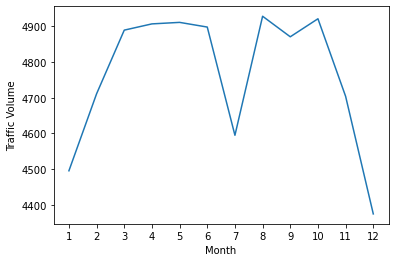

In [10]:
plt.plot(by_month['traffic_volume'])
plt.xlabel("Month")
plt.ylabel("Traffic Volume")
plt.xticks(range(1,13))
plt.show()

High traffic months:
- March-June
- August-October

Low traffic months:
- January
- July*
- December

\* July stands out from the rest of the warmer months (March to October). We'll need to look further into why July has less traffic.

Let's check the traffic volume for July each year.

<ipython-input-11-bf751072031c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_traffic['year'] = day_traffic['date_time'].dt.year


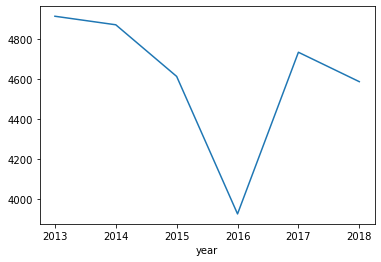

In [11]:
day_traffic['year'] = day_traffic['date_time'].dt.year
only_july = day_traffic[day_traffic['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.show()

July 2016 is the outlier, where traffic decreased significantly. This could be due to construction works - hypothesis supported by [an article](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696) from 2016.

Generally though, we can say that warmer months get heavier traffic.

## Time indicators II

<ipython-input-12-b88b639cd386>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_traffic["day"] = day_traffic['date_time'].dt.dayofweek


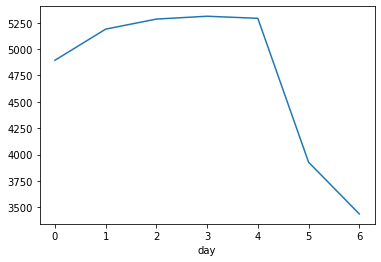

In [12]:
day_traffic["day"] = day_traffic['date_time'].dt.dayofweek

by_day = day_traffic.groupby('day').mean()

by_day['traffic_volume'].plot.line()
plt.show()

As expected, traffic is highest on business days (0-4), and lowest on the weekend (5-6).

## Time indicators III

In [13]:
day_traffic['hour'] = day_traffic['date_time'].dt.hour
bussiness_days = day_traffic.copy()[day_traffic['day'] <= 4] # 4 == Friday
weekend = day_traffic.copy()[day_traffic['day'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


<ipython-input-13-994f1990ebd6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_traffic['hour'] = day_traffic['date_time'].dt.hour


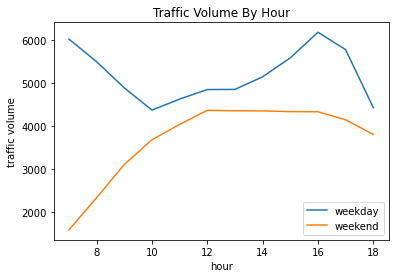

In [14]:
plt.plot(by_hour_business['traffic_volume'], label="weekday")
plt.plot(by_hour_weekend['traffic_volume'], label="weekend")

plt.title("Traffic Volume By Hour")
plt.xlabel("hour")
plt.ylabel("traffic volume")
plt.legend()

plt.show()

From the graph we can see the 2 peaks at 7AM and 4PM (traffic volume ~6k) for weekday, which coincides with rush hour traffic to/from work.

On weekends we have a more gradual rise and fall in volume throughout the day, with traffic volume not exceeding 4.5k. Our traffic volume is roughly level from 12-4PM.

### Time indicators summary

- high traffic during warmer months of the year (March-October) vs colder months
- high traffic during weekdays (Mon-Fri), vs weekends
- high traffic during rush hour (7-8AM and 4-5PM) vs midday and evenings

## Weather indicators

Our dataset provides multiple columns to explore weather data, some of which numerical:
- `temp`: Numeric Average temp in kelvin
- `rain_1h`: Numeric Amount in mm of rain that occurred in the hour
- `snow_1h`: Numeric Amount in mm of snow that occurred in the hour
- `clouds_all`: Numeric Percentage of cloud cover

We'll explore all categories to find possible correlations with traffic volume

In [15]:
day_traffic.corr()["traffic_volume"]

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
day              -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

The highest correlation value for weather is with `temp` (+0.13), with the other weather metrics showing little to no correlation.

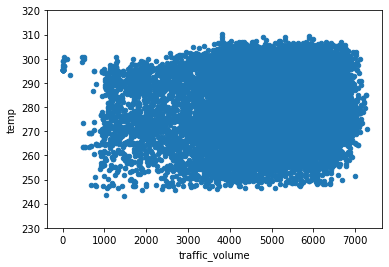

In [16]:
day_traffic.plot.scatter("traffic_volume", "temp")
plt.ylim(230,320)
plt.show()

Temperature doesn't seem like the most reliable indicator for heavy traffic.

## Weather indicators II

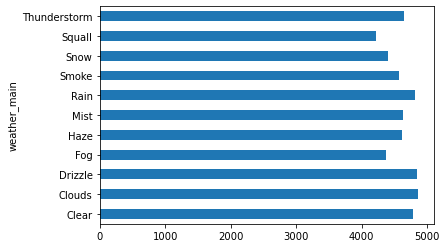

In [17]:
by_weather_main = day_traffic.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot.barh()
plt.show()

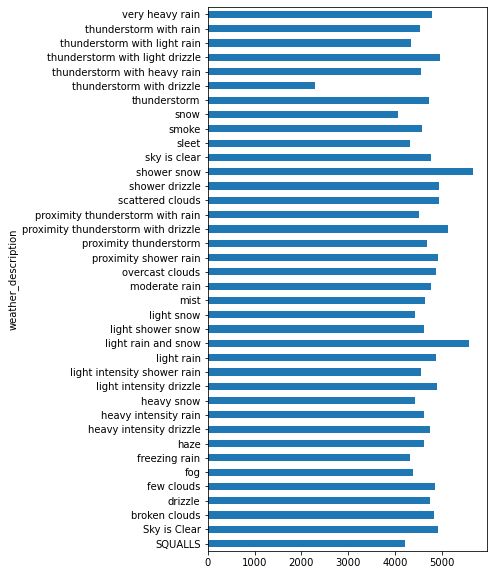

In [18]:
by_weather_description = day_traffic.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize=(5,10))
plt.show()

There are only three weather types where traffic volume exceeds 5000:
- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle

This weather isn't exceedingly bad, so it's unclear why they have the highest average traffic. It could be due to the weather being poor enough for people to move from cycling/walking to driving.

## Conclusion

In this project ew explored a couple indicators for heavy traffic on the I-94, and managed to find two types:  

**Time indicators**
- high traffic during warmer months of the year (March-October) vs colder months
- high traffic during weekdays (Mon-Fri), vs weekends
- high traffic during rush hour (7-8AM and 4-5PM) vs midday and evenings

**Weather indicators**
- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle